# NCAs as ODEs 

This notebook contains code to reproduce experiments and figures for the **Asynchronicity in Neural Cellular Automata**.

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [ ]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

EXPERIMENT_N = 2 
USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [ ]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  # wikimedia requires a user agent
  headers = {
    "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
  }
  r = requests.get(url, headers=headers)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  print(url)
  return load_image(url)

def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    if fire_rate is None:
      fire_rate = self.fire_rate
    if fire_rate < 0.0:
      noise = tf.random.normal(tf.shape(x[:, :, :, :1]), stddev=-fire_rate, dtype=tf.float32)
      y = self.perceive(x + noise, angle)
      dx = self.dmodel(y)*step_size
    else:
      y = self.perceive(x, angle)
      dx = self.dmodel(y)*step_size
      update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
      dx *= tf.cast(update_mask, tf.float32)

    x += dx
    return x


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 3, 3, 128)            6272      
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 3, 3, 16)             2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


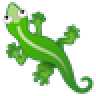

In [ ]:
#@title Target Image { vertical-output: true}
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Noto_Emoji_Oreo_1f98e.svg/128px-Noto_Emoji_Oreo_1f98e.svg.png' 
target_img = load_image(url, 48)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [ ]:
#@title Initialize Training { vertical-output: false}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

lr = 2e-3

!mkdir -p async && rm -f async/*
!mkdir -p sync && rm -f sync/*

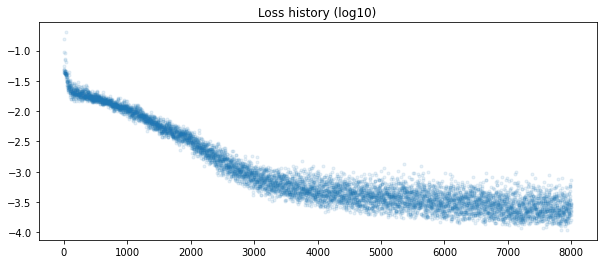

 step: 8001, log10(loss): -3.520

In [ ]:
#@title Training Loop 

for train_type, fire_rate in (("async", 0.5), ("sync", 1.0)):
  print("training %s" % train_type)
  step_i = 0
  ca = CAModel()
  loss_log = []
  loss0 = loss_f(seed).numpy()
  pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [2000], [lr, lr*0.1])
  trainer = tf.keras.optimizers.Adam(lr_sched)

  @tf.function
  def train_step(x):
    iter_n = tf.random.uniform([], 64, 96, tf.int32)
    with tf.GradientTape() as g:
      for i in tf.range(iter_n):
        x = ca(x, fire_rate=fire_rate)
      loss = tf.reduce_mean(loss_f(x))
    grads = g.gradient(loss, ca.weights)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))
    return x, loss
  
  for i in range(8000+1):
    if USE_PATTERN_POOL:
      batch = pool.sample(BATCH_SIZE)
      x0 = batch.x
      loss_rank = loss_f(x0).numpy().argsort()[::-1]
      x0 = x0[loss_rank]
      x0[:1] = seed
      if DAMAGE_N:
        damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
        x0[-DAMAGE_N:] *= damage
    else:
      x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
  
    x, loss = train_step(x0)
  
    if USE_PATTERN_POOL:
      batch.x[:] = x
      batch.commit()
  
    step_i = len(loss_log)
    loss_log.append(loss.numpy())
    
    if step_i%100 == 0:
      clear_output()
      plot_loss(loss_log)
      export_model(ca, '%s/%04d'%(train_type, step_i))
  
    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

# Is it well behaved?

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 34.24it/s]


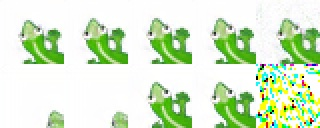

In [ ]:
#@title Qualitative 
ca_full_fire = CAModel()
ca_full_fire.load_weights('sync/%04d'%8000)
ca_half_fire = CAModel()
ca_half_fire.load_weights('async/%04d'%8000)

with VideoWriter('teaser.mp4', fps=100) as vid:
  x = np.zeros([10, 64, 64, CHANNEL_N], np.float32)
  x[:, 32, 32, 3:] = 1.0
  for i in tqdm.trange(1000):
    vid.add(zoom(tile2d(to_rgb(x), 5), 2))
    for k, xk in enumerate(x):
      if k >= 5:
        xk[:] = ca_full_fire(xk[None,...], fire_rate=1.0, step_size=tf.constant(0.1*(k+1-5)*2.5))[0]
      else:
        xk[:] = ca_half_fire(xk[None,...], fire_rate=0.5, step_size=tf.constant(0.1*(k+1)*2.5))[0]
imshow(zoom(tile2d(to_rgb(x[:, 0:32, 0:32, ...]), 5), 2))
mvp.ipython_display('teaser.mp4', loop=True)

100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s]


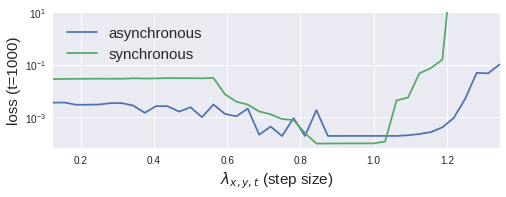

In [ ]:
#@title Quantitative
hf_x = np.zeros([40, 80, 80, CHANNEL_N], np.float32)
ff_x = np.zeros([40, 80, 80, CHANNEL_N], np.float32)
hf_x[:, 40, 40, 3:] = 1.0
ff_x[:, 40, 40, 3:] = 1.0
for i in tqdm.trange(1000):
  for j in range(40):
    hf_x[j] = ca_half_fire(hf_x[None, j,...], fire_rate=0.5, step_size=tf.constant(0.125*((j/4)+1)))[0]
    ff_x[j] = ca_full_fire(ff_x[None, j,...], fire_rate=1.0, step_size=tf.constant(0.125*((j/4)+1)))[0]

hf_x_np = []
ff_x_np = []
x_vars = []
for i in range(40):
  x_vars.append(0.125*((i/4)+1))
  hf_x_np.append(loss_f(hf_x[i]).numpy())
  ff_x_np.append(loss_f(ff_x[i]).numpy())

import pylab
import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 22})
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(x_vars, hf_x_np, label="asynchronous") 
line2, = ax.plot(x_vars, ff_x_np, label="synchronous")
ax.set_yscale('log')
ax.set_xlabel('$\lambda_{x, y, t}$ (step size)', size='x-small')
ax.set_ylabel('loss (t=1000)', size='x-small')
ax.legend(prop={'size': 15})
plt.ylim(10**(-4.2), 10.0)
plt.xlim(0.125, 1.34375)
pylab.show()
fig.savefig("async_chart.pdf", bbox_inches='tight')